In [623]:
import sys
sys.path.append('../src')

In [624]:
import pandas as pd
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource, Scope
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min
from pyomo.environ import ConstraintList
from pyomo.environ import Objective as PymObjective
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from ppopt.plot import parametric_plot
from matplotlib import rc


In [625]:
scales = TemporalScale(discretization_list=[1, 24])

In [626]:
bigM = 10**6
smallM = 0.001

In [627]:
Weather = pd.read_csv('RT 06 JUNE.csv')
Wind_df = Weather[['WGRPP_HO']][:24]
Solar_df = Weather[['PVGRPP_HO']][:24]
elec_price_df = Weather[['DAM Houston']][:24].reset_index(drop = True)
NG_price_df = Weather[['NG_Price']][:24]
GWP_df = Weather[['GWP']][:24].reset_index(drop = True)
# numpy.std(list(NG_price_df['NG_Price']))
#Gives relevancy to price values again
elec_price = elec_price_df.max()[0]
NG_price = NG_price_df.max()[0]
GWP_df = GWP_df.max()[0]

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_9800\1728792422.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\cacodcar\AppData\Local\Temp\ipykernel_9800\1728792422.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]
C:\Users\cacodcar\AppData\Local\Temp\ipykernel_9800\1728792422.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  GWP_df = GWP_df.max()

In [628]:
elec_price

187.62

In [629]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power', price= 52.69, gwp=0, scope=Scope.TWO)

Wind = Resource(name='Wind', cons_max=bigM, basis='MW', label='Wind Power', price= 60.11, gwp=0, scope=Scope.TWO)

Power_sell = Resource(name='Power', basis='MW', sell = True, revenue = 2, 
                 label='Power generated', demand = True)

Power = Resource(name='Power', basis='MW',
                 label='Power generated')

GridPower = Resource(name='GridPower', basis='MW',
                     cons_max=bigM, label='Power bought', gwp=420.62, price = elec_price, varying = [VaryingResource.DETERMINISTIC_PRICE], scope = Scope.TWO)

PowerInf = Resource(name='PowerInf', basis='MW', cons_max= bigM, label='Infinite Power', price = 0)
#The following are components of natural gas

CO2 = Resource(name='CO2', basis='kg/hr',
               label='Carbon dioxide', block='Resource')

CO2_Stack = Resource(name='CO2 to Stack', basis='kg/hr', sell=True,
               label='Carbon dioxide to Stack', block='Resource', gwp = 1, scope = Scope.ONE)

CO2_Air = Resource(name='CO2 from air', basis='kg/hr',
               label='Carbon dioxide from air', block='Resource', cons_max=bigM)

CO2_Vent = Resource(name='CO2 Vented from the process', basis='kg/hr',
               label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True, scope = Scope.ONE)

CO2cpt = Resource(name='CO2 Captured', basis='kg/hr', sell=True, label='Captured carbon dioxide', block='Resource')

CH4 = Resource(name='CH4', basis='kg/hr',
               label='Methane', block='Resource')

#Important: Natural gas consists over different components

NG = Resource(name='Natural Gas', basis='kg/hr',
                     cons_max=bigM, label='Natural Gas', gwp = 0.660979, price = NG_price, varying = [VaryingResource.DETERMINISTIC_PRICE])


# Hydrogen is what I want to sell/satisfy a specific demand for

H2 = Resource(name='Hydrogen', basis='kg/hr', label='Hydrogen', block='Resource')

H2Pure = Resource(name='Pure Hydrogen', demand = True, basis='kg/hr', label='Pure Hydrogen', block='Resource', revenue= 3.0)

# Water is required for the electrolysis process

H2O = Resource(name='H2O',
               basis='kg/hr', cons_max=bigM, label='Water', block='Resource')

#Industrial water price is 0.002 USD/kg of water
H2OFresh = Resource(name="H2O Fresh", cons_max=bigM, price = 0.002, basis='kg/hr', label='Fresh Water', block='Resource')

H2O_Air = Resource(name='H2O from air', cons_max=bigM,
               basis='kg/hr', label='Water from air', block='Resource')

H2O_Vent = Resource(name='H2O vented from the process',
               basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')


H2O_Stack = Resource(name='H2O to Stack',
               basis='kg/hr', sell= True, label='Water to Stack', block='Resource')

#Industrial water price is 0.002 USD/kg of water

# Air components

N2 = Resource(name='N2', basis='kg/hr',
               label='Nitrogen', block='Resource')

N2_SMR = Resource(name='N2 from SMR', basis='kg/hr',
               label='Nitrogen from SMR', block='Resource')

N2_WGS = Resource(name='N2 from WGS', basis='kg/hr',
               label='Nitrogen from WGS', block='Resource')

N2_FG = Resource(name='N2 from FG', basis='kg/hr',
               label='Nitrogen from FG', block='Resource')

N2_Air = Resource(name='N2 from Air', basis='kg/hr', cons_max= bigM,
               label='Nitrogen from Air', block='Resource')

N2_Vent = Resource(name='N2 vented from the process', basis='kg/hr', sell= True,
               label='Nitrogen vented from the process', block='Resource')

N2Prod = Resource(name='N2 in product stream', basis='kg/hr',
               label='Nitrogen in product stream', block='Resource')

N2_Stack = Resource(name='N2 to Stack', basis='kg/hr', sell= True,
               label='Nitrogen to stack', block='Resource')

O2 = Resource(name='O2', basis='kg/hr',
               label='Oxygen', block='Resource')

O2_Air = Resource(name='O2 from air', basis='kg/hr',
               label='Oxygen from air', block='Resource', cons_max = bigM)

O2_Vent = Resource(name='O2 vented from the process', basis='kg/hr', sell=True,
               label='Oxygen vented from the process', block='Resource')

O2_Stack = Resource(name='O2 to Stack', basis='kg/hr', sell= True,
               label='Oxygen to Stack', block='Resource')


In [630]:
'''Purchasing electricity from a traditional power production system'''

Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='Grid', basis='MW')

InfGrid = Process(name='Grid', conversion={PowerInf: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='InfGrid', basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1},
             prod_max=10, prod_min=10,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')

# capex=0.0001, fopex=0.0001, vopex=0.0001, gwp = 0.0001

WF = Process(name='WF', conversion={Wind: -1, Power: 1},
             prod_max=30, prod_min=30, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')


Grid_sell = Process(name='Grid_sell', conversion={GridPower: -1, Power_sell: 1}, prod_min=smallM, prod_max=bigM, label='Grid sell', basis='MW')

PV_sell = Process(name='PV_sell', conversion={Solar: -1, Power_sell: 1},
             prod_max=10, prod_min=10,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV sell', basis='MW')

WF_sell = Process(name='WF_sell', conversion={Wind: -1, Power_sell: 1},
             prod_max=30, prod_min=30, label='Wind mill array  sell', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')


SMR = Process(name='SMR', conversion={Power: -0.00065, NG: -3.535189, H2OFresh: -16.78877421, N2_Air: -19.2134, O2_Air: -5.88716, H2O_Air: -0.1582, CO2_Air: -0.01171, 
                                            H2Pure: 1, CO2_Stack: 9.3713,  H2O_Stack: 3.94959, N2_Stack: 19.29814, O2_Stack: 0.535434}, capex=0.0001,
               vopex=1.2, fopex=0.001, prod_min=smallM, prod_max=bigM, label='SMR', basis='kg/hr')


SMRCCS = Process(name='SMRCCS', conversion={Power: -0.00139, N2_Air: -22.2315, O2_Air: -6.811924, H2O_Air: -0.183055, CO2_Air: -0.013551, CO2_Stack: -9.3713,
                                             H2O_Vent: 3.826767, CO2cpt: 8.903, CO2_Vent: 0.46856, H2O_Stack: 0.558114, N2_Stack: 22.32218, O2_Stack: 0.6203032, }, capex=0.0001,
                vopex=1.1, fopex=0.001, prod_min=smallM, prod_max=bigM, label='SMRCCS', basis='kg/hr')

PEM = Process(name='PEM', conversion={Power: -0.157828499, H2OFresh: -7.568707483,
                                            H2Pure: 1}, capex=0.0001,
               vopex=4.668, fopex=0.001, prod_min=18.75, prod_max=18.75, label='PEM', basis='kg/hr')

In [631]:
process_set = {Grid, PV, WF, SMR, PEM,SMRCCS}

In [632]:
houston = Location(name='HO', processes=process_set, capacity_factor={PV: Solar_df, WF: Wind_df}, price_factor={GridPower: elec_price_df, NG: NG_price_df}, 
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, capacity_scale_level=1)

## Declare Scenario

In [633]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=1, 
                    purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='full_case', demand={houston: {H2Pure:10000}})

In [634]:
def model_maker(objective:str):
    if objective == 'cost':
        obj = Objective.COST
    if objective == 'gwp':
        obj = Objective.MIN_GWP
    if objective == 'scope1':
        obj = Objective.MIN_ScopeONE_GWP
    if objective == 'scope2':
        obj = Objective.MIN_ScopeTWO_GWP      

    
    model = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.DEMAND}|{Constraints.EMISSION, Constraints.SCOPEONE, Constraints.SCOPETWO}, objective=obj, demand_sign = 'geq')

    ramping_limit = 1000

    model.cons2 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            model.cons2.add(expr = model.P['HO', 'SMR', *i] - model.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    model.cons3 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            model.cons3.add(expr = model.P['HO', 'SMR', *i] - model.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit)
            
    return model

In [635]:
mods = {i: model_maker(i) for i in ['cost', 'gwp', 'scope1', 'scope2']}

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint global warming potential process scope1
constraint global warming potential resource scope1
constraint global warming potential resource consumption scope1
constraint global warming potential resource discharge scope1
constraint global warming potential location scope1
constraint global warming potential network scope1
constraint global warming potential process scope2
constraint global warming potential resource scope2
constraint global warming potential resource consumption scope2
constraint global

In [636]:
def solutioner(name,model):
    return solve(scenario=scenario, instance=model,
                     solver='gurobi', name=f"res_{name}", print_solversteps=True, saveformat = '.pkl')

In [637]:
results = {i[0]: solutioner(*i) for i in mods.items()}

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1384 rows, 1345 columns and 3557 nonzeros
Model fingerprint: 0x426c2119
Coefficient statistics:
  Matrix range     [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+06]
Presolve removed 1217 rows and 1208 columns
Presolve time: 0.00s
Presolved: 167 rows, 160 columns, 562 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1656048e+05   1.056967e+02   0.000000e+00      0s
      25    4.2158103e+05   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.215810302e+05
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build

In [638]:
for i in ['cost', 'gwp', 'scope1', 'scope2']: 
    for j in ['objective', 'Cost','global_warming_potential_location_scope1', 'global_warming_potential_location_scope2']:
        if j in results[i].output:
            
            if isinstance(results[i].output[j], dict) and list(results[i].output[j].values())[0]:
                print(f'{i}--'.upper(), f'{j}:', list(results[i].output[j].values())[0])
            if isinstance(results[i].output[j], float):
                print(f'{i}--'.upper(), f'{j}:', results[i].output[j])

COST-- objective: 421581.03018575086
COST-- global_warming_potential_location_scope1: 2249112.0
COST-- global_warming_potential_location_scope2: 43744.48
GWP-- objective: 741622.5251100103
GWP-- Cost: 706337.7323164269
GWP-- global_warming_potential_location_scope1: 112402.73773096177
GWP-- global_warming_potential_location_scope2: 68672.85896807472
SCOPE1-- objective: 112243.54799999994
SCOPE1-- Cost: 704003.016361791
SCOPE1-- global_warming_potential_location_scope1: 112243.54799999994
SCOPE1-- global_warming_potential_location_scope2: 186376.57594759154
SCOPE2-- objective: 888.8441678308349
SCOPE2-- Cost: 431888.6394682044
SCOPE2-- global_warming_potential_location_scope1: 2246115.447363056
SCOPE2-- global_warming_potential_location_scope2: 888.8441678308349


In [639]:
loc_h2 = Location(name='loc_h2', processes={InfGrid, PEM, SMR, SMRCCS}, price_factor= {NG: NG_price_df}, 
                   scales=scales, label='For producing H2', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1)
scenario_h2 = Scenario(name='scenario_h2', network=loc_h2, scales=scales,  expenditure_scale_level=0, demand_scale_level=1,                    
                       purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='h2 production', demand={loc_h2: {H2Pure:10000}})

In [640]:
loc_pow = Location(name='loc_pow', processes={PV_sell, WF_sell, Grid_sell}, capacity_factor={PV_sell: Solar_df, WF_sell: Wind_df}, price_factor= {GridPower: elec_price_df}, 
                   scales=scales, label='For generating power', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, capacity_scale_level=1)
scenario_pow_lb = Scenario(name='scenario_pow', network=loc_pow, scales=scales,  expenditure_scale_level=0, demand_scale_level=1,                    
                       purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='power generation', demand={loc_pow: {Power_sell:10000*(0.00065)}})

scenario_pow_ub = Scenario(name='scenario_pow', network=loc_pow, scales=scales,  expenditure_scale_level=0, demand_scale_level=1,                    
                       purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='power generation', demand={loc_pow: {Power_sell:10000*(0.157828499)}})



In [641]:
scenarios_ind = {'cost_h2': scenario_h2, 'scope1': scenario_h2, 'cost_pow_lb': scenario_pow_lb, 'cost_pow_ub': scenario_pow_ub, 'scope2': scenario_pow_ub}

In [642]:
from energiapy.utils.scale_utils import scale_tuple

def mod_objective_cost(instance, penalty) -> Objective:

    scale_iter = scale_tuple(
        instance=instance, scale_levels=1)

    def objective_cost_rule(instance):
        vopex = sum(instance.Vopex_network[scale_] for scale_ in scale_iter)
        cost_purch = sum(instance.B_network[resource_, scale_] for resource_, scale_ in
                         product(instance.resources_purch, scale_iter))
        emission = sum(instance.global_warming_potential_network[scale_] for scale_ in scale_iter)
        revenue = sum(instance.R_network[resource_, scale_] for resource_, scale_ in product(instance.resources_sell, scale_iter ))
        
        return vopex + cost_purch + penalty*emission - revenue 
    
    instance.objective_cost = PymObjective(
        rule=objective_cost_rule, doc='modified total cost')



In [643]:
from energiapy.model.constraints.cost import constraint_resource_revenue, constraint_location_revenue, constraint_network_revenue


def ind_model_maker(objective, penalty = 5):
    scenario = scenarios_ind[objective]
    
    if objective in ['cost_h2', 'cost_pow_lb', 'cost_pow_ub']:
        
        
        model = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.DEMAND}|{Constraints.EMISSION, Constraints.SCOPEONE, Constraints.SCOPETWO}, demand_sign = 'eq')
        constraint_resource_revenue(instance=model, location_resource_dict=scenario.location_resource_dict, revenue=scenario.revenue_dict,
                                                scheduling_scale_level=scenario.scheduling_scale_level, revenue_factor=scenario.revenue_factor)
        constraint_location_revenue(
            instance=model, network_scale_level=scenario.network_scale_level, cluster_wt=scenario.cluster_wt, scheduling_scale_level=scenario.scheduling_scale_level)
        constraint_network_revenue(
            instance=model, network_scale_level=scenario.network_scale_level)
        mod_objective_cost(model, penalty)


    if objective == 'scope1':
        model = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.DEMAND}|{Constraints.EMISSION, Constraints.SCOPEONE, Constraints.SCOPETWO}, 
                          objective = Objective.MIN_ScopeONE_GWP, demand_sign = 'geq')
        
        
    if objective == 'scope2':
        model = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.DEMAND}|{Constraints.EMISSION, Constraints.SCOPEONE, Constraints.SCOPETWO}, 
                          objective = Objective.MIN_ScopeONE_GWP, demand_sign = 'geq')
      
        
    if objective in ['cost_h2', 'scope1']:
        
        ramping_limit = 1000

        model.cons2 = ConstraintList()
        for i in scales.scale_iter(1):
            if i != (0,0):
                model.cons2.add(expr = model.P['loc_h2', 'SMR', *i] - model.P['loc_h2', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

        model.cons3 = ConstraintList()
        for i in scales.scale_iter(1):
            if i != (0,0):
                model.cons3.add(expr = model.P['loc_h2', 'SMR', *i] - model.P['loc_h2', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit)
    

    return model

In [644]:
mods_ind = {i: ind_model_maker(i, 5) for i in ['cost_h2', 'scope1', 'cost_pow_lb', 'cost_pow_ub', 'scope2']}

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint global warming potential process scope1
constraint global warming potential resource scope1
constraint global warming potential resource consumption scope1
constraint global warming potential resource discharge scope1
constraint global warming potential location scope1
constraint global warming potential network scope1
constraint global warming potential process scope2
constraint global warming potential resource scope2
constraint global warming potential resource consumption scope2
constraint global

In [645]:
results_ind = {i: solve(scenario=scenarios_ind[i], instance=mods_ind[i],
                     solver='gurobi', name=f"res_mod_{i}", print_solversteps=True, saveformat = '.pkl') for i in mods_ind}

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1335 rows, 1108 columns and 3294 nonzeros
Model fingerprint: 0x44341dc9
Coefficient statistics:
  Matrix range     [1e-04, 2e+01]
  Objective range  [1e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+06]
Presolve removed 1335 rows and 1108 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3213639e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.321363894e+06
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R)

In [646]:
for i in ['cost_h2', 'scope1', 'cost_pow_lb', 'cost_pow_ub', 'scope2']: 
    for j in ['objective', 'Cost','global_warming_potential_location_scope1', 'global_warming_potential_location_scope2']:
        if j in results_ind[i].output:
            
            if isinstance(results_ind[i].output[j], dict) and list(results_ind[i].output[j].values())[0]:
                print(f'{i}--'.upper(), f'{j}:', list(results_ind[i].output[j].values())[0])
            if isinstance(results_ind[i].output[j], float):
                print(f'{i}--'.upper(), f'{j}:', results_ind[i].output[j])

COST_H2-- objective: 3321363.8940073764
COST_H2-- global_warming_potential_location_scope1: 112243.54799999994
SCOPE1-- objective: 112243.54799999994
SCOPE1-- Cost: 683580.8893977471
SCOPE1-- global_warming_potential_location_scope1: 112243.54799999994
COST_POW_LB-- objective: 12921.693700773201
COST_POW_LB-- global_warming_potential_location_scope2: 888.8441678308349
COST_POW_UB-- objective: 80661241.36412024
COST_POW_UB-- global_warming_potential_location_scope2: 15770129.862439984
SCOPE2-- objective: 0.0
SCOPE2-- Cost: 1198982606.5203521
SCOPE2-- global_warming_potential_location_scope2: 10094880000.0


In [647]:

A = numpy.array([[0, 0, -1.2, -4.668, 1, 0], [0, 1, -1, -1, 0, 0], [0, 0, -9.3713, 0, 0, 1], [1, 0, -0.0065, -0.1578, 0, 0], [1, 0, 0, 0, 0,0], 
                 [-1, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0], [0, 0, 0, -1, 0, 0], [0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, -1]])
b = numpy.array(11*[0]).reshape(11, 1)
c = numpy.array([0, -5, 0, 0, 1, 0.8]).reshape(-1,1)
F = numpy.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

CRa = numpy.vstack((numpy.eye(2), -numpy.eye(2)))
CRb = numpy.array([50, 10000*(0.157828499), -20, -10000*(0.065)]).reshape(4, 1)
H = numpy.array([[1,0],[0,0],[0,0],[0,0],[0,0],[0,0]])

prog_h2 = MPLP_Program(A, b, c, H, CRa, CRb, F, equality_indices=list(range(5)))
solution_h2 = solve_mpqp(prog_h2, mpqp_algorithm.graph)


First region (0, 1, 2, 3, 4, 7, 10)


In [648]:
A = numpy.array([[1, -1, -1, -1, 0, 0], [0, -52.69, -60.11, -187.62, 1, 0], [0, 0, 0, 42.62, 0, 1], [1, 0, 0, 0, 0, 0], 
                 [-1, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0], [0, 0, 0, -1, 0, 0], [0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, -1]])
b = numpy.array(10*[0]).reshape(10, 1)
c = numpy.array([0, 0, 0, 0, 1, 0.8]).reshape(-1,1)
F = numpy.array([[0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

CRa = numpy.vstack((numpy.eye(2), -numpy.eye(2)))
CRb = numpy.array([50, 10000*(0.157828499), -20, -10000*(0.065)]).reshape(4, 1)
H = numpy.array([[-1,0],[0,0],[0,0],[0,0],[0,0],[0,0]])

prog_pow = MPLP_Program(A, b, c, H, CRa, CRb, F, equality_indices=list(range(4)))
solution_pow = solve_mpqp(prog_pow, mpqp_algorithm.graph)


First region (0, 1, 2, 3, 6, 7, 9)


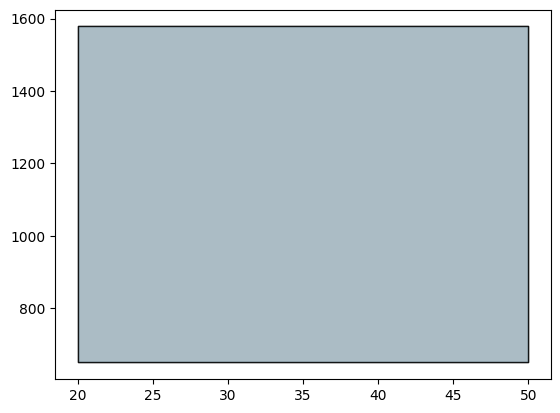

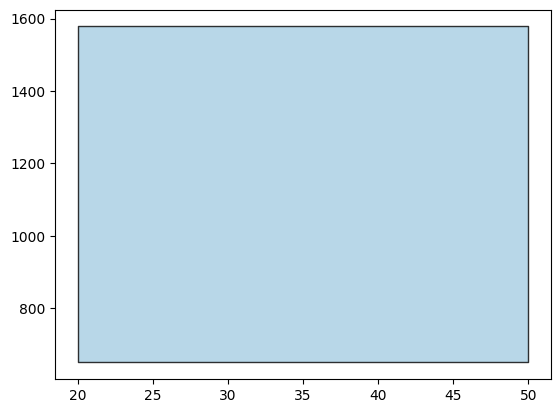

In [650]:
parametric_plot(solution_h2, save_path='transport', save_format='svg', show=True)
parametric_plot(solution_pow, save_path='transport', save_format='svg', show=True)

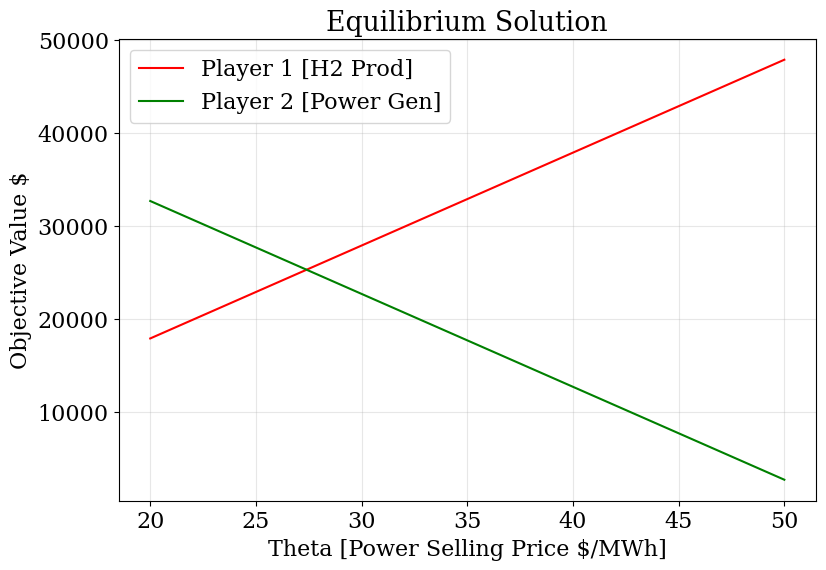

In [649]:

# saves the plot as 'transport.svg' in the current working directory
# parametric_plot(solution_h2, save_path='transport', save_format='svg', show=True)
# parametric_plot(solution_pow, save_path='transport', save_format='svg', show=True)

theta_s = numpy.linspace(50, 20, 100)
theta_g = numpy.linspace(10000*(0.157828499),10000*(0.065), 100)
# sols_h2 = [prog_h2.solve_theta(numpy.array([[1.1, t]]).T) for t in theta_g]
# sols_pow = [prog_pow.solve_theta(numpy.array([[1.1, t]]).T) for t in theta_g]
sols_h2 = [prog_h2.solve_theta(numpy.array([[t, 1000]]).T) for t in theta_s]
sols_pow = [prog_pow.solve_theta(numpy.array([[t, 1000]]).T) for t in theta_s]
obj_h2 = [i.obj[0][0] for i in sols_h2]
obj_pow = [i.obj[0][0] for i in sols_pow]

rc('font',**{'family':'serif','serif':['Times New Roman'], 'size': 16})
fig, ax = plt.subplots(figsize = (9, 6))

ax.plot(theta_s, obj_h2, label='Player 1 [H2 Prod]', color='red')
ax.plot(theta_s, obj_pow, label='Player 2 [Power Gen]', color='green')
plt.title('Equilibrium Solution')
plt.ylabel('Objective Value $')
plt.xlabel('Theta [Power Selling Price $/MWh]')
plt.grid(alpha = 0.3)
plt.legend()
plt.rcdefaults()
